# Определение стоимости автомобилей

### Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

---

<h2>Содержание</h2>

<div class="toc">
  <ul>
    <li><a href="#Подготовка-данных">Предобработка данных</a></li>
       <ul>
        <li><a href="#Разделим-и-закодируем-выборку">Подготовка данных</a></li>
      </ul>
    <li><a href="#Обучение-моделей">Обучение моделей</a></li>
       <ul>
        <li><a href="#LightGBM">LightGBM</a></li>
        <li><a href="#CatBoostRegressor">CatBoostRegressor</a></li>
        <li><a href="#RandomForestRegressor">RandomForestRegressor</a></li>
        <li><a href="#LinearRegression">LinearRegression</a></li>
      </ul>
    <li><a href="#Анализ-моделей">Анализ-моделей</a></li>
    <li><a href="#Тестирование-лучшей-модели">Тестирование лучшей модели</a></li>
    <li><a href="#Общий-вывод">Общий вывод</a></li>
  </ul>
</div>

<style>
  .toc ul {
    font-size: 14px;
  }
</style>

---

### Цели и задачи

**Цель** - Построить модель, которая умеет её определять рыночную стоимость своего автомобиля.

**Задачи**:
    
    1. Загрузить и осмотреть данные.
    2. Выполнить предобработку данных.
    3. Подготовить данные для обучения моделей.
    4. Обучить разные модели и использовать разные гиперпараметры.
    5. Провести анализ обученых моделей.
    6. Провести тестирование лучшей модели.
    7. Сделать выводы по итогам работы.
    
---

### Описание данных

#### Признаки
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

#### Целевой признак
- `Price` — цена (евро)

---

## Подготовка данных

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import time

In [2]:
df = pd.read_csv("/datasets/autos.csv")

In [3]:
def my_info ():
    df.info()
    display(df.head(-5))
    display(df.describe())
    
my_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354359,2016-03-28 13:48:07,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,2016-03-28 00:00:00,0,75223,2016-04-02 18:16:20
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Такие столбцы как 

*DateCrawled*, *NumberOfPictures*, *PostalCode*, *RegistrationMonth* 

нам не нужны, для модели они не несут никакой ценности. В оставшихся столбцах даты приведу в порядок тип данных.

In [4]:
df = df.drop(["DateCrawled", "NumberOfPictures", "PostalCode", "RegistrationMonth"], axis=1)

#формат даты
df["DateCreated"] = pd.to_datetime(df["DateCreated"], format='%Y-%m-%d %H:%M:%S')
df["LastSeen"] = pd.to_datetime(df["LastSeen"], format='%Y-%m-%d %H:%M:%S')

Посмотрим уникальные значения в столбцах. 

In [5]:
for column in df.columns:
    print('Уникальные значения столбца:', column)
    try:
        df_sort = df[column].unique()
        df_sort.sort()
        print(df_sort)
    except:
        print(df[column].unique())
print('Количество пропусков в столбце')    
print(df.isna().mean())

Уникальные значения столбца: Price
[    0     1     2 ... 19998 19999 20000]
Уникальные значения столбца: VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца: RegistrationYear
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 999

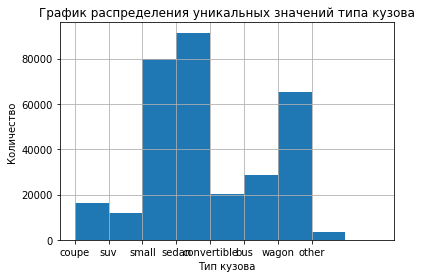

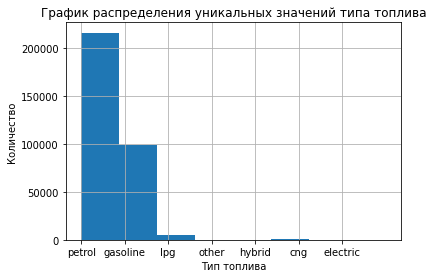

In [6]:
df['VehicleType'].hist(bins = 9,range=(0,9));
plt.title('График распределения уникальных значений типа кузова')
plt.ylabel('Количество')
plt.xlabel('Тип кузова')
plt.show()


df['FuelType'].hist(bins = 8,range=(0,7));
plt.title('График распределения уникальных значений типа топлива')
plt.ylabel('Количество')
plt.xlabel('Тип топлива')
plt.show()

Пропусков в данных достаточно много, некоторые достигают 20% данных, поэтому:

* Kilometer - Данные выглядят вполне правдоподобно, так и оставляем.
* Brand - Здесь тоже все в порядке, пропусков нет.
* Repaired - О ремонте нам ничего ничего не известно, переведем в boolean формат.
* Gearbox - Значения коробки передач так же переведем в boolean формат.
* VehicleType - Пропущенные значения типа кузова тоже неизвестно, представим их как *unknown*.
* Model - Пропущенные значения представим как *other*.
* FuelType - Тип топлива наиболее встречаемый в данных *petrol*, этим значением и заполним пропуски.

In [7]:
df['Repaired'] = pd.Series(np.where(df['Repaired'].values == 'yes', 1, 0), df.index)
df['Gearbox'] = pd.Series(np.where(df['Gearbox'].values == 'auto', 1, 0), df.index)

In [8]:
df["Model"] = df["Model"].fillna("other") 
df["VehicleType"] = df["VehicleType"].fillna("unknown")

df["FuelType"] = df["FuelType"].fillna(df["FuelType"].mode().values[0])

Исходя из того какой модельный ряд некоторых раритетных машин представлен, год регистрации ограничу в пределах 1950-2020.

In [9]:
def lem_change(value): 
    if value > 2020:
        return 2020
    elif value < 1950: 
        return 1950
    else:
        return value
df["RegistrationYear"] = df["RegistrationYear"].apply(lem_change) 

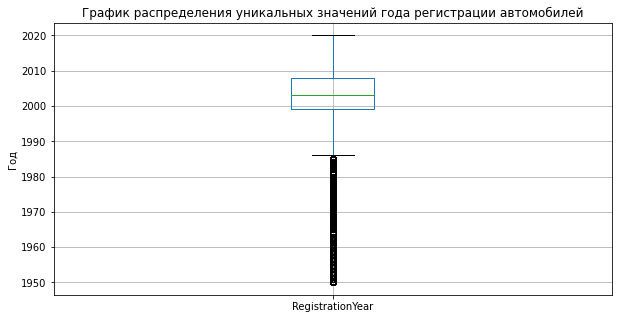

In [10]:
df.boxplot(['RegistrationYear'], figsize=(10,5))
plt.title('График распределения уникальных значений года регистрации автомобилей')
plt.ylabel('Год')
plt.show()

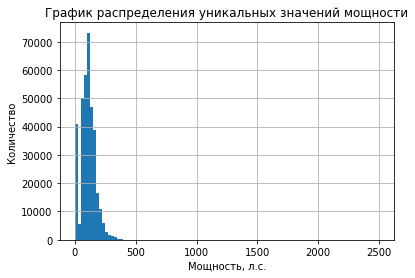

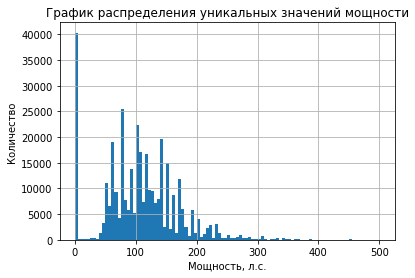

In [11]:
df['Power'].hist(bins = 100, range=(0,2500));
plt.title('График распределения уникальных значений мощности')
plt.ylabel('Количество')
plt.xlabel('Мощность, л.с.')
plt.show()

df['Power'].hist(bins = 100, range=(0,500));
plt.title('График распределения уникальных значений мощности')
plt.ylabel('Количество')
plt.xlabel('Мощность, л.с.')
plt.show()

В столбце *Power* нет пропусков, но есть некорректные данные. Есть выбросы и аномалии в значении "0". Ограничем значения 10-2000 л.с.

In [12]:
df=df.query('Power > 10 & Power < 2000')
df.loc[df['Power'] < 10]['Power'].count()

0

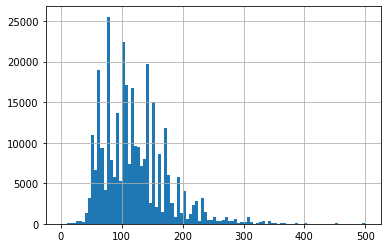

In [13]:
df['Power'].hist(bins = 100, range=(0,500));

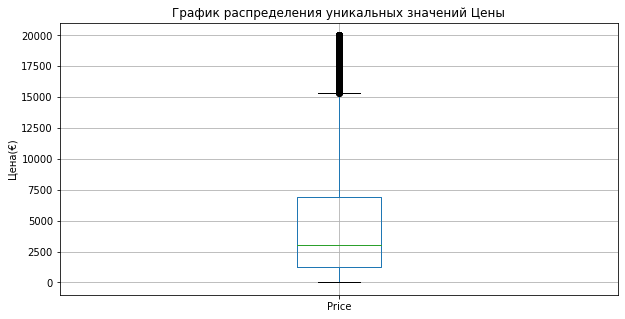

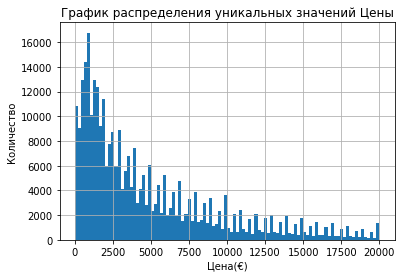

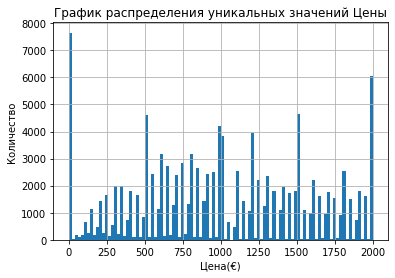

In [14]:
df.boxplot(['Price'],figsize=(10,5))
plt.title('График распределения уникальных значений Цены')
plt.ylabel('Цена(€)')
plt.show()

df['Price'].hist(bins = 100,range=(0,20000));
plt.title('График распределения уникальных значений Цены')
plt.ylabel('Количество')
plt.xlabel('Цена(€)')
plt.show()

df['Price'].hist(bins = 100,range=(0,2000));
plt.title('График распределения уникальных значений Цены')
plt.ylabel('Количество')
plt.xlabel('Цена(€)')
plt.show()

Удалим данные стоимости автомобилей ниже 10€. Таких данных мало, а нулевых значений не слишком много. Верхний предел ограничим в 15000€. Цена не должна быть нереальной, поэтому ограничим по времени не слишком превышающем время продаж (если считать, что *LastSeen* была совершена продажа по указанной цене). 

In [15]:
# среднее время продаж
time_sales = (df["LastSeen"] - df["DateCreated"]).median()
print(time_sales)

6 days 12:47:44


In [16]:
# Цена не должна быть
df = df[((df['Price'] > 10) & (((df["LastSeen"] - df["DateCreated"]).median()) < time_sales*3) & (df['Price'] < 15000))]
df.loc[df['Price'] < 10]['Price'].count()

0

Больше столбцы с датой нам не нужны.

In [17]:
df = df.drop_duplicates()
df = df.drop(["LastSeen", "DateCreated"], axis=1)
df=df.reset_index(drop=True)
my_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291013 entries, 0 to 291012
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             291013 non-null  int64 
 1   VehicleType       291013 non-null  object
 2   RegistrationYear  291013 non-null  int64 
 3   Gearbox           291013 non-null  int64 
 4   Power             291013 non-null  int64 
 5   Model             291013 non-null  object
 6   Kilometer         291013 non-null  int64 
 7   FuelType          291013 non-null  object
 8   Brand             291013 non-null  object
 9   Repaired          291013 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.2+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,9800,suv,2004,1,163,grand,125000,gasoline,jeep,0
1,1500,small,2001,0,75,golf,150000,petrol,volkswagen,0
2,3600,small,2008,0,69,fabia,90000,gasoline,skoda,0
3,650,sedan,1995,0,102,3er,150000,petrol,bmw,1
4,2200,convertible,2004,0,109,2_reihe,150000,petrol,peugeot,0
...,...,...,...,...,...,...,...,...,...,...
291003,4400,sedan,2008,0,105,leon,150000,gasoline,seat,0
291004,999,convertible,2000,0,95,megane,150000,petrol,renault,0
291005,1690,wagon,2004,0,55,fabia,150000,petrol,skoda,0
291006,1490,small,1998,0,50,lupo,150000,petrol,volkswagen,0


,Price,RegistrationYear,Gearbox,Power,Kilometer,Repaired
count,291013.000000,291013.000000,291013.000000,291013.000000,291013.000000,291013.000000
mean,4175.650913,2003.021497,0.182906,117.873549,130345.723387,0.100717
std,3670.829513,6.783040,0.386590,61.348009,35079.634481,0.300954
min,11.000000,1950.000000,0.000000,11.000000,5000.000000,0.000000
25%,1280.000000,1999.000000,0.000000,75.000000,125000.000000,0.000000
50%,2900.000000,2003.000000,0.000000,109.000000,150000.000000,0.000000
75%,6200.000000,2007.000000,0.000000,143.000000,150000.000000,0.000000
max,14999.000000,2020.000000,1.000000,1999.000000,150000.000000,1.000000


### Разделим и закодируем выборку

In [18]:
df_train, df_test = train_test_split(df, test_size = 0.25, random_state = 54321)
print(df_train.shape)
print(df_test.shape)

(218259, 10)
(72754, 10)


Категориальные признаки будуем кодировать *Ordinal Encoder*.

In [19]:
encoder = OrdinalEncoder()
encoder.fit(df_train[['VehicleType', 'Model', 'FuelType', 'Brand']])

df_train.loc[:, ['VehicleType', 'Model', 'FuelType', 'Brand']] = encoder.transform(df_train[['VehicleType', 'Model', 'FuelType', 'Brand']])
df_test.loc[:, ['VehicleType', 'Model', 'FuelType', 'Brand']] = encoder.transform(df_test[['VehicleType', 'Model', 'FuelType', 'Brand']])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [20]:
#features
features_train = df_train.drop('Price', axis = 1)
features_test = df_test.drop('Price', axis = 1)
print(features_train.shape)
print(features_test.shape)

#target
target_train = df_train['Price']
target_test = df_test['Price']

(218259, 9)
(72754, 9)


Маштабируем признаки.

In [21]:
#Для масштабирования методом scaler зафиксируем численные признаки
numeric =  features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

#Масштабируем численные признаки
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


print(features_train.shape)
print(features_test.shape)

features_train.head()

(218259, 9)
(72754, 9)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
39761,-0.281598,-1.622303,-0.473541,-0.708350,1.759080,-3.576216,0.644130,0.231503,-0.334622
134859,1.393681,0.293942,-0.473541,0.366130,-1.165627,0.559520,-1.574146,-1.498604,-0.334622
168784,0.137221,-1.180093,-0.473541,-1.204264,-0.391440,0.559520,0.644130,0.231503,-0.334622
92396,1.393681,0.588749,-0.473541,-0.146314,-0.721186,0.559520,-1.574146,-0.821606,-0.334622
161407,-0.281598,-0.148269,2.111748,1.473672,-0.749860,0.559520,0.644130,-1.197716,-0.334622


In [22]:
df_train.corr().style.background_gradient(cmap='coolwarm')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,-0.093439,0.415006,0.217674,0.389561,-0.039621,-0.334701,-0.291999,-0.099250,-0.193132
VehicleType,-0.093439,1.000000,0.159654,0.027629,-0.000123,-0.123329,0.063208,-0.047857,-0.040441,0.020953
RegistrationYear,0.415006,0.159654,1.000000,0.007765,0.065780,-0.009000,-0.221041,-0.201579,-0.006887,-0.080329
Gearbox,0.217674,0.027629,0.007765,1.000000,0.346629,-0.050026,0.030694,-0.130240,-0.105046,-0.007229
Power,0.389561,-0.000123,0.065780,0.346629,1.000000,-0.115399,0.123549,-0.171866,-0.275433,-0.022992
Model,-0.039621,-0.123329,-0.009000,-0.050026,-0.115399,1.000000,-0.038045,-0.020601,0.455262,0.011812
Kilometer,-0.334701,0.063208,-0.221041,0.030694,0.123549,-0.038045,1.000000,-0.167755,-0.051098,0.064731
FuelType,-0.291999,-0.047857,-0.201579,-0.130240,-0.171866,-0.020601,-0.167755,1.000000,0.027401,0.025865
Brand,-0.099250,-0.040441,-0.006887,-0.105046,-0.275433,0.455262,-0.051098,0.027401,1.000000,-0.009581
Repaired,-0.193132,0.020953,-0.080329,-0.007229,-0.022992,0.011812,0.064731,0.025865,-0.009581,1.000000


### Вывод
* Данные были очищены от  существенных выбросов, суммарно было удалено 63357 признака, что составляет около 18%.
* Проверена корреляция: все в рамках разумных пределов, наиболее коррелирующим с целевым признаком является признак отвечающий за мощность и год регистрации.
* Разделили выборку. Категориальные признаки закодировали. Провели маштабирование.

## Обучение моделей

In [23]:
def grid_model (model, param):
    model_grid = GridSearchCV (estimator = model, 
                               param_grid = param, # параметры
                               scoring = "neg_root_mean_squared_error", # метрика
                               cv = 5,
                               verbose=100)
                                      

    #подбор параметров и обучение
    start = time.time()
    model_grid.fit(features_train, target_train)
    print("Подбор параметров за %.2f секунд" %(time.time() - start)) 
    print("Лучшие параметры:", model_grid.best_params_)
    print("Модель обучается за %.2f секунд" %model_grid.refit_time_)
    
    #считаем скорость предсказания в модели
    start = time.time()
    model_grid.predict(features_train)
    time_to_predict = (time.time() - start)
    print("Модель предсказывает за %.2f секунд" %time_to_predict)
    
    #высчитываем качество предсказания модели
    rmse = model_grid.best_score_ * -1    
    print("RMSE обученной модели:", rmse)  
    
    return model_grid, rmse, model_grid.refit_time_, time_to_predict

### LightGBM

In [24]:
param_lightgbm = {'max_depth': [8, 10],
                  "learning_rate":np.arange(0.1,1,0.15)}


model_LGB = lgb.LGBMRegressor(metric = 'RMSE', objective ='regression', boosting_type = "gbdt")

model_grid_lgbm, rmse_lgbm, time_fit_lgbm, time_predict_lgbm = grid_model (model_LGB, param_lightgbm)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START learning_rate=0.1, max_depth=8.............................
[CV 1/5; 1/12] END ...........learning_rate=0.1, max_depth=8; total time= 6.1min
[CV 2/5; 1/12] START learning_rate=0.1, max_depth=8.............................
[CV 2/5; 1/12] END ...........learning_rate=0.1, max_depth=8; total time= 5.3min
[CV 3/5; 1/12] START learning_rate=0.1, max_depth=8.............................
[CV 3/5; 1/12] END ...........learning_rate=0.1, max_depth=8; total time= 5.4min
[CV 4/5; 1/12] START learning_rate=0.1, max_depth=8.............................
[CV 4/5; 1/12] END ...........learning_rate=0.1, max_depth=8; total time= 3.3min
[CV 5/5; 1/12] START learning_rate=0.1, max_depth=8.............................
[CV 5/5; 1/12] END ...........learning_rate=0.1, max_depth=8; total time= 1.1min
[CV 1/5; 2/12] START learning_rate=0.1, max_depth=10............................
[CV 1/5; 2/12] END ..........learning_rate=0.1, 

### CatBoostRegressor

In [25]:
param_catboost = {'max_depth': [5, 10],
                  "learning_rate":np.arange(0.1,1,0.2)}

cat = CatBoostRegressor(loss_function = "RMSE")

model_catboost, rmse_catboost, time_fit_catboost, time_predict_catboost = grid_model (cat, param_catboost)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START learning_rate=0.1, max_depth=5.............................
0:	learn: 3461.3368774	total: 74.6ms	remaining: 1m 14s
1:	learn: 3268.3759934	total: 97.8ms	remaining: 48.8s
2:	learn: 3096.0357145	total: 119ms	remaining: 39.5s
3:	learn: 2952.0329771	total: 141ms	remaining: 35.1s
4:	learn: 2821.2381202	total: 162ms	remaining: 32.1s
5:	learn: 2709.7554181	total: 183ms	remaining: 30.3s
6:	learn: 2612.0875202	total: 204ms	remaining: 29s
7:	learn: 2523.3210148	total: 225ms	remaining: 27.9s
8:	learn: 2444.8141758	total: 246ms	remaining: 27.1s
9:	learn: 2378.1024576	total: 267ms	remaining: 26.5s
10:	learn: 2315.3377803	total: 288ms	remaining: 25.9s
11:	learn: 2264.3890763	total: 309ms	remaining: 25.4s
12:	learn: 2215.4579422	total: 333ms	remaining: 25.3s
13:	learn: 2175.2204429	total: 354ms	remaining: 25s
14:	learn: 2133.7197357	total: 376ms	remaining: 24.7s
15:	learn: 2099.2281122	total: 396ms	remaining: 24.3s
16:	l

### RandomForestRegressor

In [27]:
param_forest = {'max_depth': np.arange(5, 10, 2),
                "n_estimators":[10, 50, 100]}

rfr = RandomForestRegressor (n_jobs=-1)

model_rfr, rmse_rfr, time_fit_rfr, time_predict_rfr = grid_model (rfr, param_forest)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=5, n_estimators=10................................
[CV 1/5; 1/9] END ..............max_depth=5, n_estimators=10; total time=   1.2s
[CV 2/5; 1/9] START max_depth=5, n_estimators=10................................
[CV 2/5; 1/9] END ..............max_depth=5, n_estimators=10; total time=   1.2s
[CV 3/5; 1/9] START max_depth=5, n_estimators=10................................
[CV 3/5; 1/9] END ..............max_depth=5, n_estimators=10; total time=   1.2s
[CV 4/5; 1/9] START max_depth=5, n_estimators=10................................
[CV 4/5; 1/9] END ..............max_depth=5, n_estimators=10; total time=   1.2s
[CV 5/5; 1/9] START max_depth=5, n_estimators=10................................
[CV 5/5; 1/9] END ..............max_depth=5, n_estimators=10; total time=   1.2s
[CV 1/5; 2/9] START max_depth=5, n_estimators=50................................
[CV 1/5; 2/9] END ..............max_depth=5, n_es

### LinearRegression

In [65]:
df_train_ohe, df_test_ohe = train_test_split(df, test_size = 0.25, random_state = 54321)
print(df_train_ohe.shape)
print(df_test_ohe.shape)

(218259, 10)
(72754, 10)


In [66]:
#features
features_train_ohe = df_train_ohe.drop('Price', axis = 1)
features_test_ohe = df_test_ohe.drop('Price', axis = 1)
print(features_train_ohe.shape)
print(features_test_ohe.shape)

#target
target_train_ohe = df_train_ohe['Price']
target_test_ohe = df_test_ohe['Price']

(218259, 9)
(72754, 9)


In [67]:
features_train_ohe = pd.get_dummies(features_train_ohe, drop_first=True)
features_test_ohe = pd.get_dummies(features_test_ohe, drop_first=True)

In [68]:
lin_model = LinearRegression(n_jobs=-1)
    
#подбор обучение
start = time.time()
lin_model.fit(features_train_ohe, target_train)
time_fit_linear = (time.time() - start)
print("Модель обучается за %.2f секунд" %time_fit_linear)
    
#считаем скорость предсказания в модели
start = time.time()
predict_lr = lin_model.predict(features_train_ohe)
time_predict_linear = (time.time() - start)
print("Модель предсказывает за %.2f секунд" %time_to_predict)
    
#высчитываем качество предсказания модели
rmse_linear = ((mean_squared_error(target_train, predict_lr))**0.5)   
print("RMSE обученной модели:", rmse_linear)  

#model_linear, rmse_linear, time_fit_linear, time_predict_linear = grid_model (lin_model, lin_param)

Модель обучается за 24.66 секунд
Модель предсказывает за 0.08 секунд
RMSE обученной модели: 2245.9943849556103


### Вывод
Обучил такие модели как:
* LightGBM,
* CatBoostRegressor,
* RandomForestRegressor,
* LinearRegression

и получил их показатели.

## Анализ моделей

In [70]:
# выводим результаты
comparison_tabl = pd.DataFrame(index=['Время обучения (с.)','Время предсказания(с.)', 'Качество моделей (RMSE)'], columns=['LightGBM','CatBoostRegressor','RandomForestRegressor', "LinearRegression"])
comparison_tabl['LightGBM'] = time_fit_lgbm, time_predict_lgbm, rmse_lgbm
comparison_tabl['CatBoostRegressor'] = time_fit_catboost, time_predict_catboost, rmse_catboost, 
comparison_tabl['RandomForestRegressor'] = time_fit_rfr, time_predict_rfr, rmse_rfr
comparison_tabl['LinearRegression'] = time_fit_linear, time_predict_linear, rmse_linear
comparison_tabl

,LightGBM,CatBoostRegressor,RandomForestRegressor,LinearRegression
Время обучения (с.),3.792973,54.709456,24.062607,24.657375
Время предсказания(с.),1.208149,0.918479,1.558110,0.894163
Качество моделей (RMSE),1410.977328,1342.168592,1668.099919,2245.994385


В условии указано, что решающим факторами при выборе модели являются следующие показатели:

* Время обучения
* Время предсказания
* Качество предсказаний

1) Качество предсказаний у *LightGBM* и *CatBoostRegressor* выше других моделей *RandomForestRegressor*, *LinearRegression*. Поэтому последние две модели отбросим.

2) По времени предсказаний модели отличаются не сильно, хотя *LightGBM* незначительно отстает.

3) По времени обучения *LightGBM* значительно лидирует относительно *CatBoostRegressor*.

По итогу ни одна модель не модель не стала лучшей во всех позициях, но наиболее сбалансированные результаты показала *LightGBM*, поэтому считаю что иммено эта модель лучше всего подходит для поставленной задачи

## Тестирование лучшей модели

Проведем тестирование модели

In [75]:
model_LGB_fianl = lgb.LGBMRegressor(metric = 'RMSE', objective ='regression', boosting_type = "gbdt", learning_rate= 0.4, max_depth= 10)

#обучение
start = time.time()
model_LGB_fianl.fit(features_test, target_test)
print("Модель обучается за %.2f секунд" %(time.time() - start))
    
#считаем скорость предсказания модели
start = time.time()
final_predict = model_LGB_fianl.predict(features_test)
print("Модель предсказывает за %.2f секунд" %(time.time() - start))
    
#высчитываем качество предсказания модели
rmse_final = ((mean_squared_error(target_test, final_predict))**0.5)    
print("RMSE обученной модели:", rmse_final)    

Модель обучается за 189.42 секунд
Модель предсказывает за 0.41 секунд
RMSE обученной модели: 1293.6439338385753


### Вывод 
RMSE должно быть меньше 2500, значит модель соответствует условию.

## Общий вывод

* Выполнил предобработку данных, обработал пропуски и аномалии. Изучил данные.
* Подготовил выборки и провел кодирование и маштабирование признаков.
* Обучил такие модели как *LightGBM*, *CatBoostRegressor*, *RandomForestRegressor*,  *LinearRegression*.
* Провел анализ ключевых показателей при выборе модели и на его основе выбрал лучшую.